In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gseapy as gp
from tqdm import tqdm
from adjustText import adjust_text
import seaborn as sns
import anndata
from scipy.spatial import cKDTree
from scipy.spatial import distance

In [2]:
adata = sc.read_h5ad('ABC_cleaned.h5ad')
adata_HQ = adata[adata.obs.subclass_label_confidence > 0.5]

adata_HQ.X = adata_HQ.layers['counts'].toarray().copy()
sc.pp.normalize_total(adata_HQ)
sc.pp.log1p(adata_HQ)

/oak/stanford/groups/quake/doug/resources/miniconda3/envs/Vizgen_2/lib/python3.9/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/oak/stanford/groups/quake/doug/resources/miniconda3/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [3]:
Cerebellum = adata_HQ[adata_HQ.obs.Brain_Region == 'Cerebellum']
Hippocampus = adata_HQ[adata_HQ.obs.Brain_Region == 'Hippocampus']

In [4]:
def plot_proximity(ad,batch,cell1, cell2,threshold=30,cell1_name = 'Microglia',cell2_name='Granule'):
    test_ad = ad[ad.obs.batchID == batch]

    cell1_mask = test_ad.obs['subclass_label_transfer'] == cell1
    cell1_coords = test_ad.obs.loc[cell1_mask, ['x', 'y']]

    cell2_mask = test_ad.obs['subclass_label_transfer'].isin([cell2])
    cell2_coords = test_ad.obs.loc[cell2_mask, ['x', 'y']]

    tree = cKDTree(cell1_coords)
    distances, indices = tree.query(cell2_coords, distance_upper_bound=30)

    test_ad.obs['highlight'] = 'Other'  # Initialize all cells as "Other"

    test_ad.obs.loc[cell1_mask, 'highlight'] = cell1_name
    test_ad.obs.loc[cell2_mask, 'highlight'] = np.where(distances < 30, f'Nearby {cell2_name}', f'Far {cell2_name}')

    fig, ax = plt.subplots(figsize=(14, 14))
    sc.pl.spatial(
        test_ad,
        color='highlight',
        palette=['green', 'brown', 'blue', 'darkgrey'],  # Colors: 'Microglia', 'Nearby Granule', 'Far Granule', 'Other'
        spot_size=15,
        ax=ax
    )
    fig.savefig(f'figures/Peri_{cell2_name}_{batch}.pdf', format='pdf')
    
def label_microglia_layers(ad, cell_type_col='updated_celltype', region_col='Brain_Region', 
                           granule_cell_type='Granule cells', purkinje_cell_type='Purkinje cells', 
                           microglia_cell_type='Microglia NN', batch_col = 'batchID', distance_threshold=5):
    """
    Labels microglia in the cerebellum based on their proximity to Purkinje cells and Granule cells.
    The function adds a new column 'Cerebellum_layer' to adata.obs with the values:
    'Molecular layer', 'Granule layer', or 'White matter'.
    
    Parameters:
    adata : AnnData
        Annotated data matrix.
    cell_type_col : str
        Column name in adata.obs that contains the cell type information.
    region_col : str
        Column name in adata.obs that contains the region information.
    granule_cell_type : str
        Name of the Granule cell type in the cell_type_col.
    purkinje_cell_type : str
        Name of the Purkinje cell type in the cell_type_col.
    microglia_cell_type : str
        Name of the Microglia cell type in the cell_type_col.
    distance_threshold : float
        Distance threshold (in microns) to define proximity to Granule cells for the Granule layer.
    
    Returns:
    AnnData
        AnnData object with an added 'Cerebellum_layer' column in adata.obs.
    """
    
    ad.obs['Cerebellum_layer'] = 'White matter'

    # Iterate over each unique batchID
    for batch_id in ad.obs[batch_col].unique():
        print(batch_id)
        # Subset the data for the current batch
        batch_mask = ad.obs[batch_col] == batch_id
        batch_data = ad[batch_mask]

        # Identify Microglia within the current batch and cerebellum
        microglia_mask = (batch_data.obs['subclass_label_transfer'] == microglia_cell_type) & (batch_data.obs[region_col] == 'Cerebellum')
        # Get coordinates of Granule and Purkinje cells within the current batch
        granule_coords = batch_data[batch_data.obs[cell_type_col] == granule_cell_type].obs[['x', 'y']].values
        purkinje_coords = batch_data[batch_data.obs[cell_type_col] == purkinje_cell_type].obs[['x', 'y']].values

        # Get coordinates of Microglia within the current batch
        microglia_coords = batch_data[microglia_mask].obs[['x', 'y']].values

        # Skip calculation if granule_coords or purkinje_coords is empty
        if len(granule_coords) == 0 or len(purkinje_coords) == 0 or len(microglia_coords) == 0:
            continue

        # Calculate distances from Microglia to Granule and Purkinje cells
        distances_to_granule = np.min(distance.cdist(microglia_coords, granule_coords), axis=1)
        distances_to_purkinje = np.min(distance.cdist(microglia_coords, purkinje_coords), axis=1)

        # Determine if Microglia are within the Granule layer
        granule_layer_mask = distances_to_granule <= distance_threshold
        batch_data.obs.loc[microglia_mask, 'Cerebellum_layer'] = np.where(granule_layer_mask, 'Granule layer', 'White matter')

        # Determine if Microglia are closer to Purkinje cells than Granule cells (Molecular layer)
        molecular_layer_mask = distances_to_purkinje < distances_to_granule

        # Apply the molecular layer mask only to the subset of microglia
        microglia_indices = batch_data.obs.index[microglia_mask]
        batch_data.obs.loc[microglia_indices[molecular_layer_mask & ~granule_layer_mask], 'Cerebellum_layer'] = 'Molecular layer'

        # Update the original adata with the modified batch_data
        ad.obs.loc[batch_mask, 'Cerebellum_layer'] = batch_data.obs['Cerebellum_layer']

    return ad

def calculate_layer_percentages(adata, age_col='Age', layer_col='Cerebellum_layer'):

    # Filter for microglia cells
    microglia_data = adata[adata.obs['subclass_label_transfer'] == 'Microglia NN']

    # Group by age and layer, then count the occurrences
    group_counts = microglia_data.obs.groupby([age_col, layer_col]).size().unstack(fill_value=0)

    # Calculate the percentage of microglia in each layer
    layer_percentages = (group_counts.T / group_counts.sum(axis=1)).T * 100

    return layer_percentages

def plot_layer_percentages(layer_percentages,savefig=None):
    # Create the stacked bar plot
    ax = layer_percentages.plot(kind='bar', stacked=True, figsize=(10, 7), color=['#4daf4a', '#377eb8', '#ff7f00'])

    # Set labels and title
    ax.set_xlabel('Age')
    ax.set_ylabel('Percentage of Microglia')
    ax.set_title('Percentage of Microglia in Different Cerebellar Layers at Each Age')
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=0)
    
    # Display the legend
    plt.legend(title='Cerebellar Layer', loc='upper right')
    if savefig == None:
        pass
    else:
        plt.savefig(savefig, format='pdf')
    # Show the plot
    plt.show()

/tmp/ipykernel_10491/2084509405.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_ad.obs['highlight'] = 'Other'  # Initialize all cells as "Other"


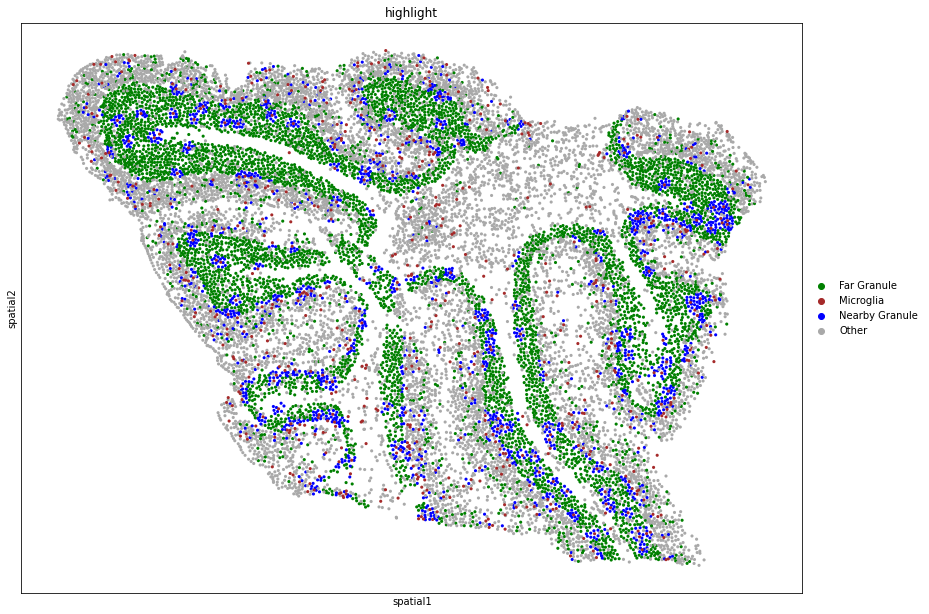

In [5]:
plot_proximity(Cerebellum,'24-mo-female-5','Microglia NN', 'CB Granule Glut')

/tmp/ipykernel_10491/2084509405.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_ad.obs['highlight'] = 'Other'  # Initialize all cells as "Other"


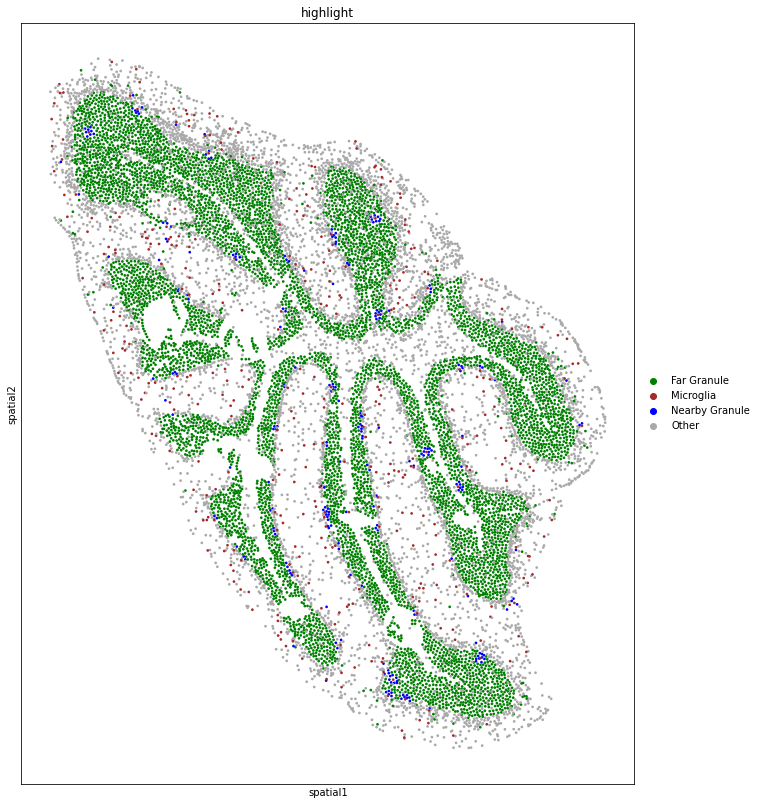

In [6]:
plot_proximity(Cerebellum,'3-mo-female-1-rev2','Microglia NN', 'CB Granule Glut')

/tmp/ipykernel_10491/2084509405.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_ad.obs['highlight'] = 'Other'  # Initialize all cells as "Other"


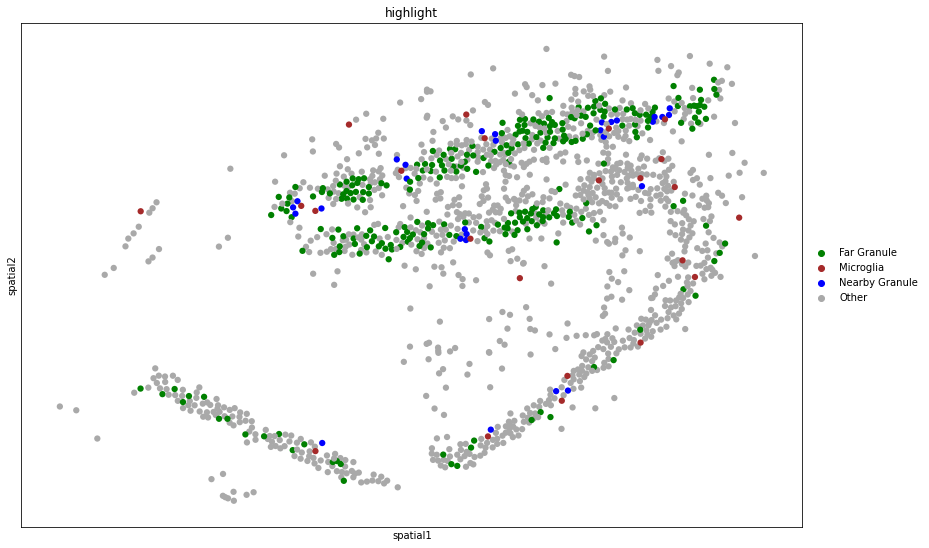

In [7]:
plot_proximity(Hippocampus,'3-mo-female-2','Microglia NN', 'DG Glut')

/tmp/ipykernel_10491/2084509405.py:13: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  test_ad.obs['highlight'] = 'Other'  # Initialize all cells as "Other"


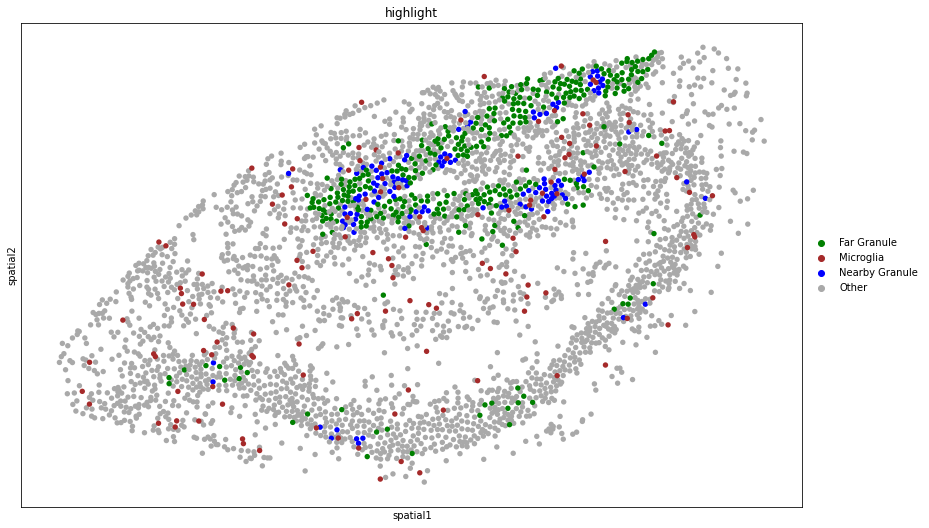

In [8]:
plot_proximity(Hippocampus,'24-mo-female-3','Microglia NN', 'DG Glut')

In [9]:
# Now we are calculating the number of cells within each layer of the CB
adata_cer_regions = label_microglia_layers(Cerebellum, distance_threshold=30)

/tmp/ipykernel_10491/2084509405.py:57: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['Cerebellum_layer'] = 'White matter'


3-mo-female-2
24-mo-female-1
24-mo-female-3
24-mo-female-5
24-mo-male-2
24-mo-male-4-rev2
3-mo-male-1
3-mo-male-2
3-mo-male-3-rev2
3-mo-female-1-rev2
3-mo-female-3


/tmp/ipykernel_10491/2084509405.py:105: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = microglia_data.obs.groupby([age_col, layer_col]).size().unstack(fill_value=0)


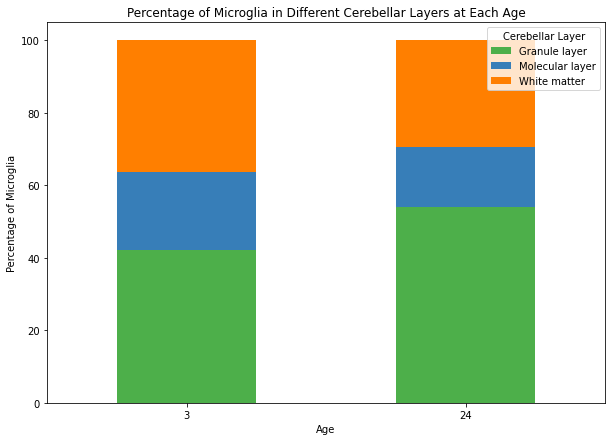

In [10]:
layer_percentages = calculate_layer_percentages(adata_cer_regions)
plot_layer_percentages(layer_percentages,savefig='figures/percentage_microglia.pdf')

In [11]:
layer_percentages

Cerebellum_layer,Granule layer,Molecular layer,White matter
Age,,,
3,42.291951,21.327876,36.380173
24,53.975466,16.583371,29.441163
